## Temperature forecast using LSTM

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (12, 9)
mpl.rcParams['axes.grid'] = False

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
csv_path = "/content/gdrive/MyDrive/climate_analysis/Chennai_hourly.csv"

In [4]:
df = pd.read_csv(csv_path)

Let's take a glance at the data.

## The weather dataset


This dataset contains 10 different features such as air temperature, surface pressure, and specific humidity. These were collected every 1 hour, beginning in 2012. 

In [5]:
df.head()

,YEAR,MO,DY,HR,DATE,DATE_HOUR,T2M,QV2M,PRECTOTCORR,WS10M,PS,ALLSKY_SFC_UV_INDEX,T2MDEW,T2MWET,WD10M,WS10M.1
0,2012,1,1,5,01-01-2012,1-1-2012 Hr - 5,23.53,17.21,0.51,3.22,100.67,0.00,22.71,23.12,107.64,3.22
1,2012,1,1,6,01-01-2012,1-1-2012 Hr - 6,24.30,17.76,0.49,3.20,100.76,0.02,23.21,23.76,110.43,3.20
2,2012,1,1,7,01-01-2012,1-1-2012 Hr - 7,25.62,18.37,0.50,3.99,100.86,0.52,23.81,24.72,113.76,3.99
3,2012,1,1,8,01-01-2012,1-1-2012 Hr - 8,26.51,18.43,0.45,4.69,100.90,1.73,23.86,25.18,116.82,4.69
4,2012,1,1,9,01-01-2012,1-1-2012 Hr - 9,27.32,18.37,0.44,5.18,100.87,3.95,23.82,25.57,118.07,5.18


In [6]:
len(df)

87696

In [7]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [8]:
def denormalize(arr, mean, sd):
  
  arr = arr*sd + mean
  return arr

In [9]:
TRAIN_SPLIT = 65000

Setting seed to ensure reproducibility.

In [10]:
tf.random.set_seed(69)

In [11]:
uni_data = df['T2M']
uni_data.index = df['DATE_HOUR']
uni_data.head()

DATE_HOUR
1-1-2012 Hr - 5    23.53
1-1-2012 Hr - 6    24.30
1-1-2012 Hr - 7    25.62
1-1-2012 Hr - 8    26.51
1-1-2012 Hr - 9    27.32
Name: T2M, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7d0c05f290>],
      dtype=object)

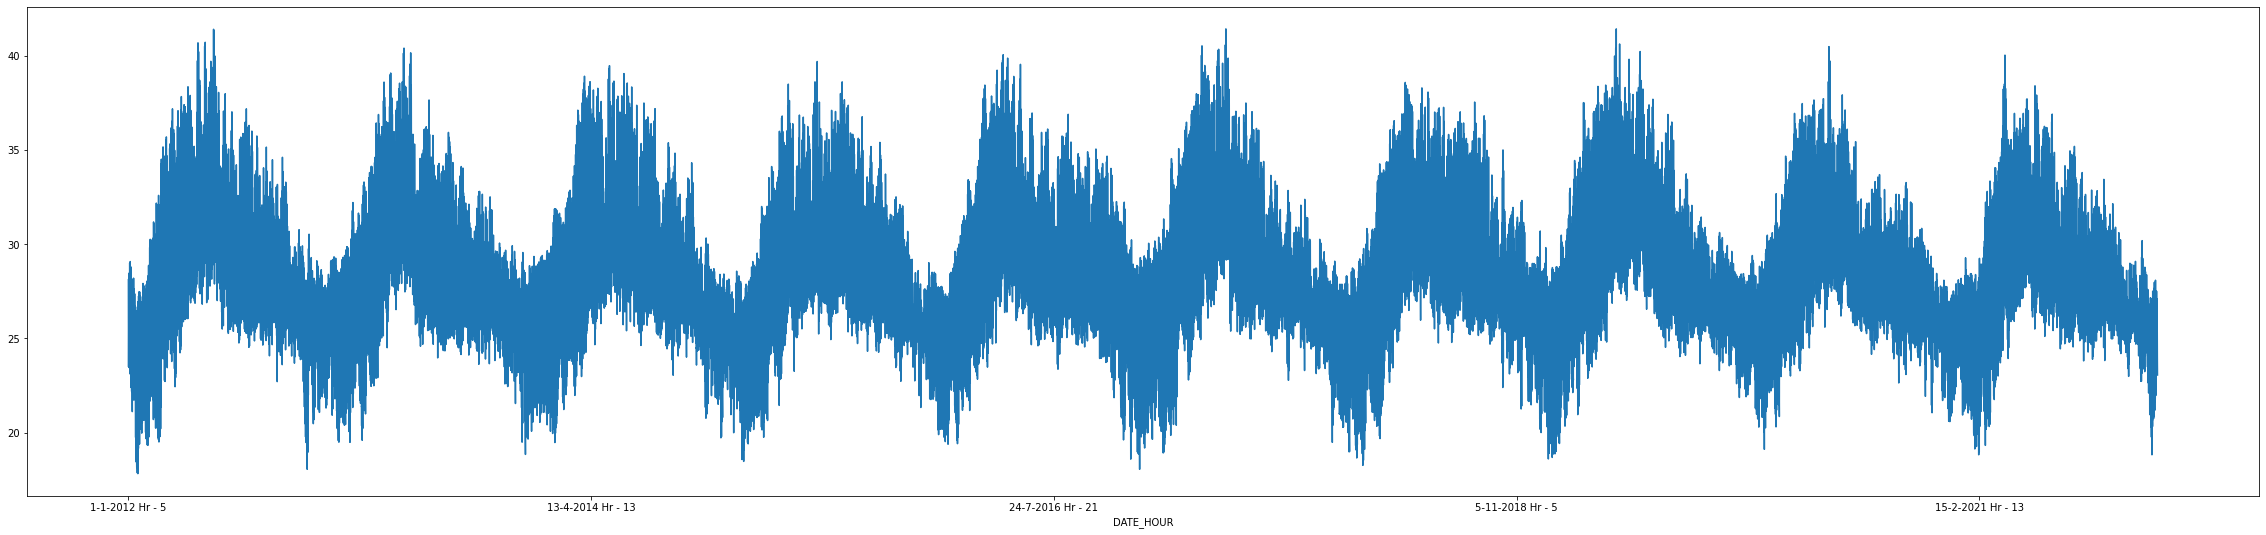

In [12]:
uni_data.plot(subplots=True, figsize = (40,9))

In [13]:
uni_data = uni_data.values

In [14]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

Let's normalize the data.

In [15]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

Let's now create the data for the univariate model. For part 1, the model will be given the last 20 recorded temperature observations, and needs to learn to predict the temperature at the next time step. 

In [16]:
univariate_past_history = 24
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

This is what the `univariate_data` function returns.

In [17]:
print ('Single window of past history')
print (x_train_uni[1])
print ('\n Target temperature to predict')
print (y_train_uni[1])

Single window of past history
[[-0.94850676]
 [-0.61281921]
 [-0.38648443]
 [-0.18049434]
 [-0.03808144]
 [ 0.02803883]
 [ 0.03058192]
 [-0.05588306]
 [-0.16269273]
 [-0.2898471 ]
 [-0.4729494 ]
 [-0.75014594]
 [-0.85441253]
 [-0.91798971]
 [-0.97393764]
 [-1.00699777]
 [-1.03497174]
 [-1.05785952]
 [-1.08583349]
 [-1.10617819]
 [-1.14686759]
 [-1.15703994]
 [-1.16212611]
 [-1.14941067]]

 Target temperature to predict
-0.9968254242806726


Now that the data has been created, let's take a look at a single example. The information given to the network is given in blue, and it must predict the value at the red cross.

In [18]:
def create_time_steps(length):
  time_steps = []
  for i in range(-length, 0, 1):
    time_steps.append(i)
  return time_steps

In [19]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

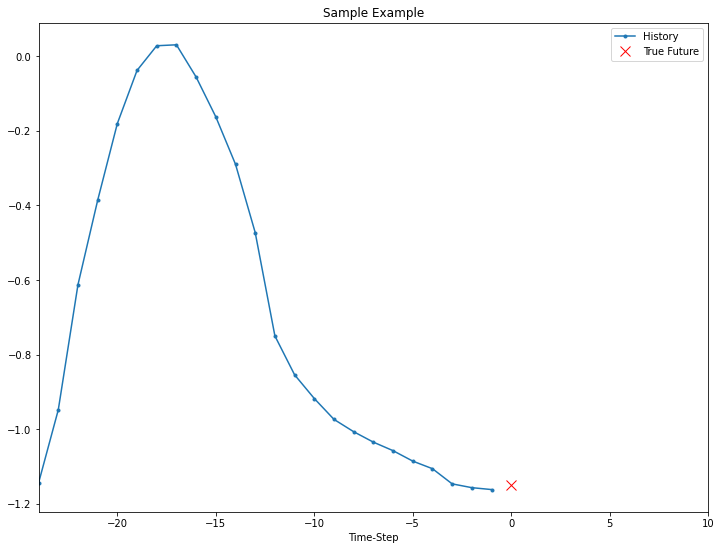

In [20]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

### Moving average model. (For reference)
Before proceeding to train a model, let's first set a simple baseline. Given an input point, the baseline method looks at all the history and predicts the next point to be the average of the last 20 observations.

In [21]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

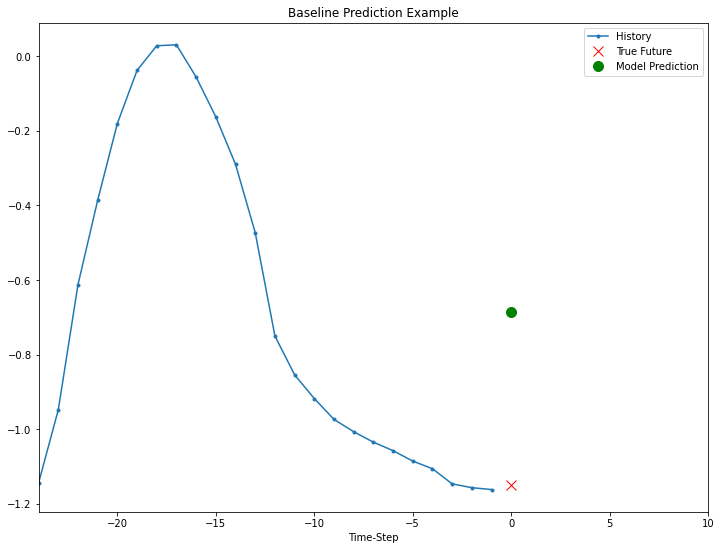

In [22]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

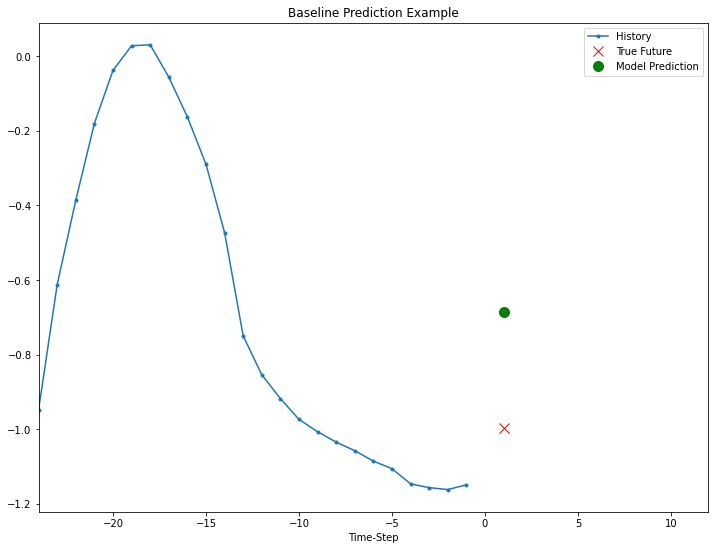

In [23]:
show_plot([x_train_uni[1], y_train_uni[1], baseline(x_train_uni[1])], 1,
           'Baseline Prediction Example')

Let's see if you can beat this baseline using a recurrent neural network.

In [24]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [25]:
x_train_uni.shape[-2:]

(24, 1)

### Recurrent neural network

A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state summarizing the information they've seen so far. 

Let's now use `tf.data` to shuffle, batch, and cache the dataset.

In [26]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

Let's make a sample prediction, to check the output of the model. 

In [27]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

8/8 [==============================] - 5s 3ms/step
(256, 1)


Let's train the model now. 

In [28]:
EVALUATION_INTERVAL = 400
EPOCHS = 20

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/20
400/400 [==============================] - 4s 6ms/step - loss: 0.4013 - val_loss: 0.1111
Epoch 2/20
400/400 [==============================] - 2s 5ms/step - loss: 0.0902 - val_loss: 0.0540
Epoch 3/20
400/400 [==============================] - 2s 5ms/step - loss: 0.0567 - val_loss: 0.0452
Epoch 4/20
400/400 [==============================] - 2s 5ms/step - loss: 0.0489 - val_loss: 0.0414
Epoch 5/20
400/400 [==============================] - 2s 5ms/step - loss: 0.0452 - val_loss: 0.0397
Epoch 6/20
400/400 [==============================] - 2s 5ms/step - loss: 0.0432 - val_loss: 0.0383
Epoch 7/20
400/400 [==============================] - 2s 5ms/step - loss: 0.0420 - val_loss: 0.0376
Epoch 8/20
400/400 [==============================] - 2s 5ms/step - loss: 0.0406 - val_loss: 0.0371
Epoch 9/20
400/400 [==============================] - 2s 5ms/step - loss: 0.0401 - val_loss: 0.0364
Epoch 10/20
400/400 [==============================] - 2s 5ms/step - loss: 0.0392 - val_loss: 0.0359

In [29]:
simple_lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 8)                 320       
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


In [30]:
for x, y in val_univariate.take(20):
  observed = denormalize(simple_lstm_model.predict(x)[0], uni_train_mean, uni_train_std)
  actual = denormalize(y[0].numpy(), uni_train_mean, uni_train_std)
  mape = abs(observed[0] - actual)*100/actual
  print("Observed->", observed[0])
  print("Actual->", actual)
  print("MAPE->", mape)
  print("-------------------------")

        

8/8 [==============================] - 0s 2ms/step
Observed-> 37.795925
Actual-> 37.94
MAPE-> 0.37974396315007475
-------------------------
8/8 [==============================] - 0s 2ms/step
Observed-> 28.837225
Actual-> 29.07
MAPE-> 0.8007397305567658
-------------------------
8/8 [==============================] - 0s 2ms/step
Observed-> 28.459444
Actual-> 28.62
MAPE-> 0.5609921522693682
-------------------------
8/8 [==============================] - 0s 2ms/step
Observed-> 35.91426
Actual-> 35.89
MAPE-> 0.06759783855617701
-------------------------
8/8 [==============================] - 0s 3ms/step
Observed-> 26.43369
Actual-> 26.29
MAPE-> 0.5465542694242734
-------------------------
8/8 [==============================] - 0s 2ms/step
Observed-> 28.116652
Actual-> 28.04
MAPE-> 0.27336496089222734
-------------------------
8/8 [==============================] - 0s 2ms/step
Observed-> 32.664062
Actual-> 32.48
MAPE-> 0.5666948891625713
-------------------------
8/8 [=====================

#### Predict using the simple LSTM model
Now that you have trained your simple LSTM, let's try and make a few predictions.

8/8 [==============================] - 0s 3ms/step


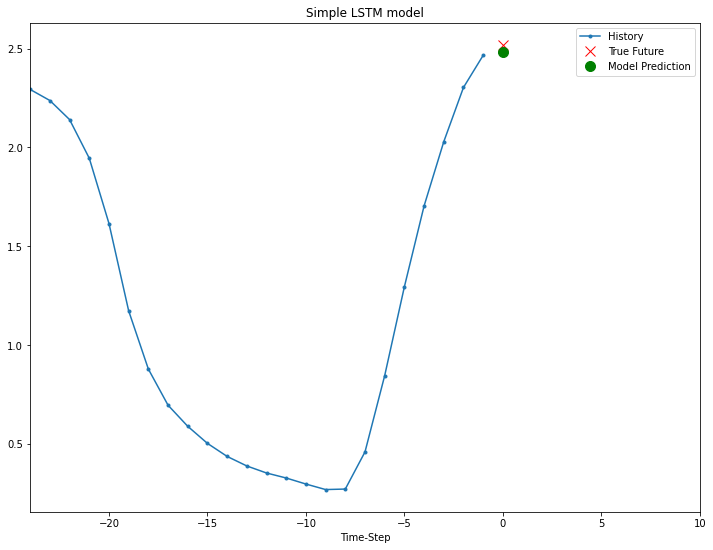

8/8 [==============================] - 0s 2ms/step


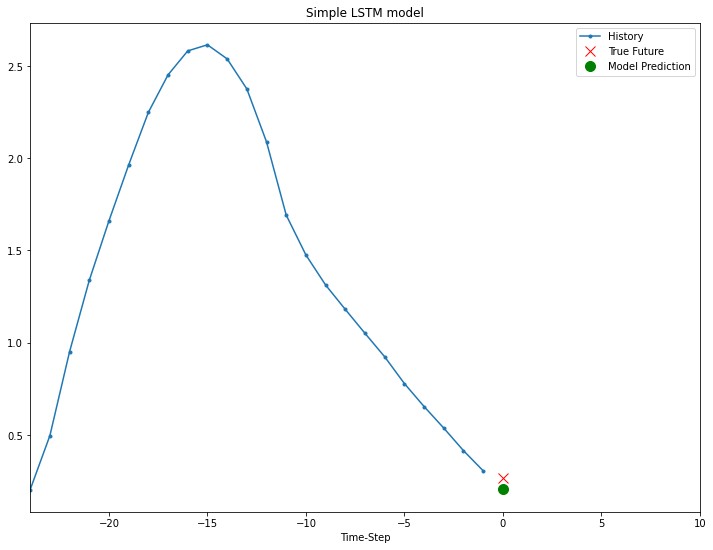

8/8 [==============================] - 0s 2ms/step


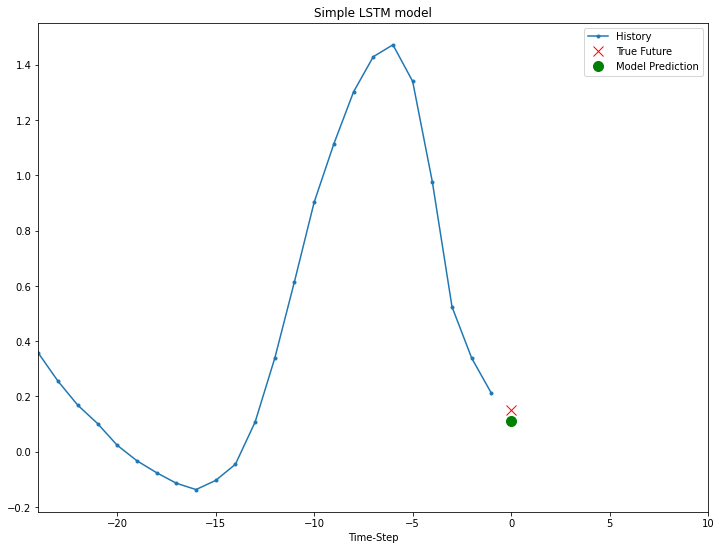

8/8 [==============================] - 0s 3ms/step


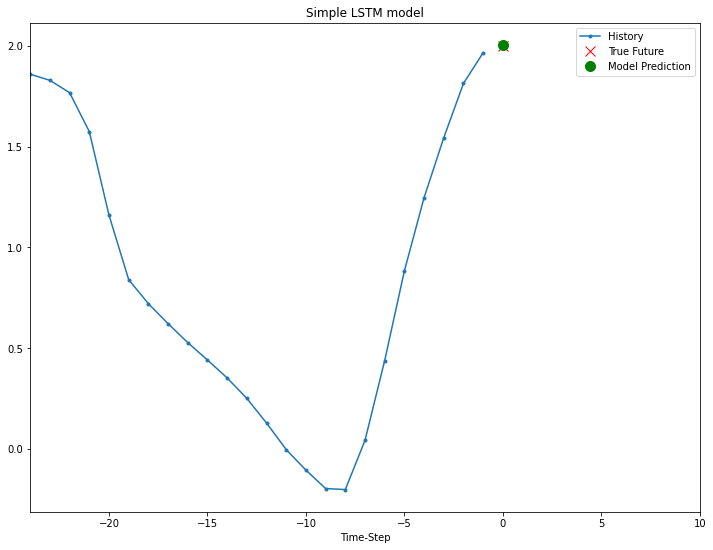

8/8 [==============================] - 0s 3ms/step


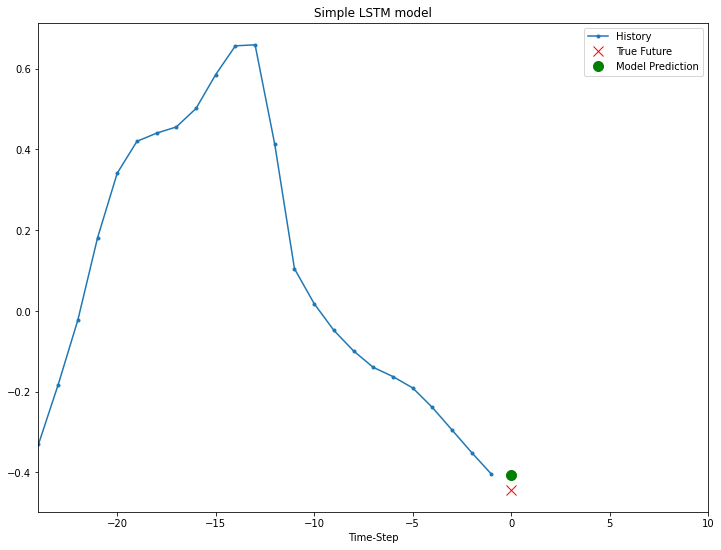

In [31]:
for x, y in val_univariate.take(5):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

This looks better than the baseline. Now that you have seen the basics, let's move on to part two, where you will work with a multivariate time series.

## Part 2: Forecast a multivariate time series

The original dataset contains fourteen features. For simplicity, this section considers only three of the original fourteen. The features used are air temperature, atmospheric pressure, and air density. 

To use more features, add their names to this list.

In [32]:
features_considered = ['PS', 'T2M', 'QV2M']

In [33]:
features = df[features_considered]
features.index = df['DATE_HOUR']
features.head()

,PS,T2M,QV2M
DATE_HOUR,,,
1-1-2012 Hr - 5,100.67,23.53,17.21
1-1-2012 Hr - 6,100.76,24.30,17.76
1-1-2012 Hr - 7,100.86,25.62,18.37
1-1-2012 Hr - 8,100.90,26.51,18.43
1-1-2012 Hr - 9,100.87,27.32,18.37


Let's have a look at how each of these features vary across time.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7ca65bb150>,
      dtype=object)

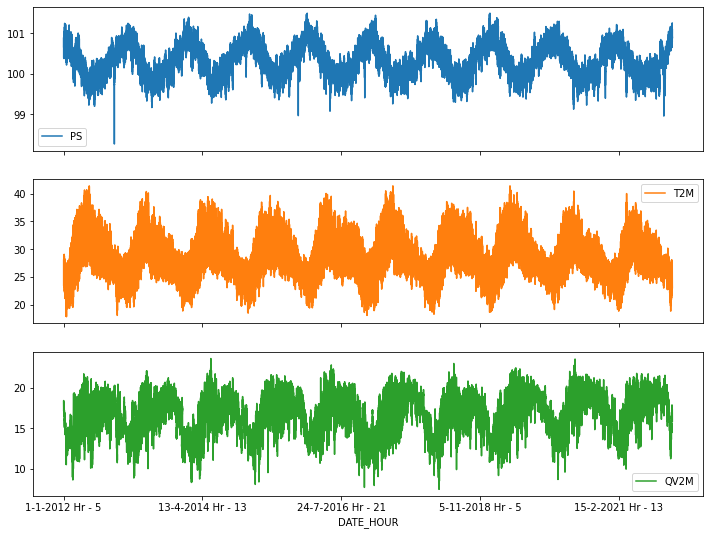

In [34]:
features.plot(subplots=True)

As mentioned, the first step will be to normalize the dataset using the mean and standard deviation of the training data.

In [35]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
data_mean

array([100.34139262,  28.02974492,  16.53616538])

In [36]:
dataset = (dataset-data_mean)/data_std

### Single step model
In a single step setup, the model learns to predict a single point in the future based on some history provided.

The below function performs the same windowing task as below, however, here it samples the past observation based on the step size given.

In [37]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [38]:
past_history = 336
future_target = 12
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

The network is shown data from the last five 14 days, i.e. 336 observations that are sampled every hour. The sampling is done every one hour since a drastic change is not expected within 60 minutes. Thus, 336 observation represent history of the last five days.  For the single step prediction model, the label for a datapoint is the temperature 12 hours into the future. In order to create a label for this, the temperature after 12 observations is used.

Let's look at a single data-point.


In [39]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (56, 3)


In [40]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [41]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

Let's check out a sample prediction.

In [42]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

8/8 [==============================] - 0s 4ms/step
(256, 1)


In [43]:
EPOCHS_NEW = 10
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS_NEW,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Epoch 1/10
400/400 [==============================] - 4s 7ms/step - loss: 0.3482 - val_loss: 0.1669
Epoch 2/10
400/400 [==============================] - 2s 6ms/step - loss: 0.1675 - val_loss: 0.1564
Epoch 3/10
400/400 [==============================] - 2s 6ms/step - loss: 0.1645 - val_loss: 0.1568
Epoch 4/10
400/400 [==============================] - 3s 6ms/step - loss: 0.1614 - val_loss: 0.1536
Epoch 5/10
400/400 [==============================] - 3s 6ms/step - loss: 0.1591 - val_loss: 0.1551
Epoch 6/10
400/400 [==============================] - 3s 6ms/step - loss: 0.1586 - val_loss: 0.1491
Epoch 7/10
400/400 [==============================] - 3s 7ms/step - loss: 0.1558 - val_loss: 0.1536
Epoch 8/10
400/400 [==============================] - 3s 6ms/step - loss: 0.1573 - val_loss: 0.1529
Epoch 9/10
400/400 [==============================] - 2s 6ms/step - loss: 0.1541 - val_loss: 0.1489
Epoch 10/10
400/400 [==============================] - 2s 6ms/step - loss: 0.1542 - val_loss: 0.1496

In [44]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

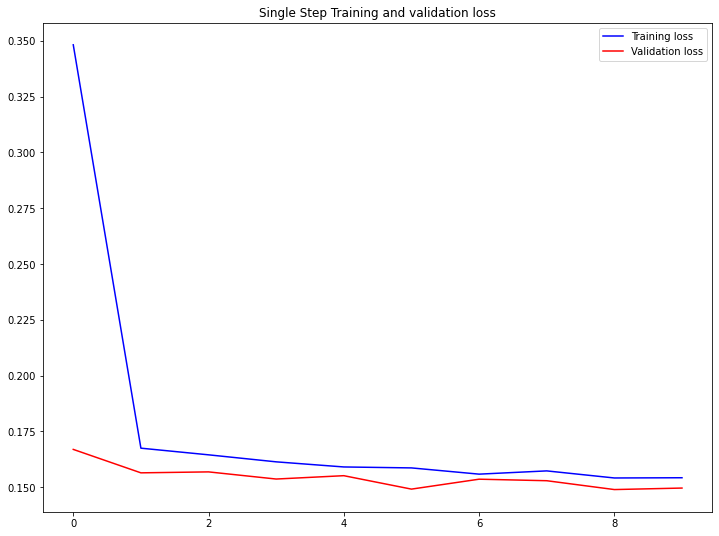

In [45]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

#### Predict a single step future
Now that the model is trained, let's make a few sample predictions. The model is given the history of three features over the past five days sampled every hour (120 data-points), since the goal is to predict the temperature, the plot only displays the past temperature. The prediction is made one day into the future (hence the gap between the history and prediction). 

8/8 [==============================] - 0s 3ms/step


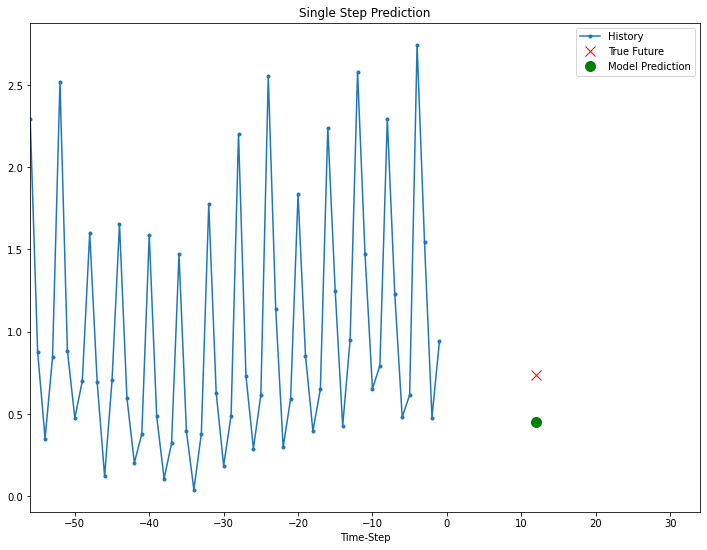

8/8 [==============================] - 0s 3ms/step


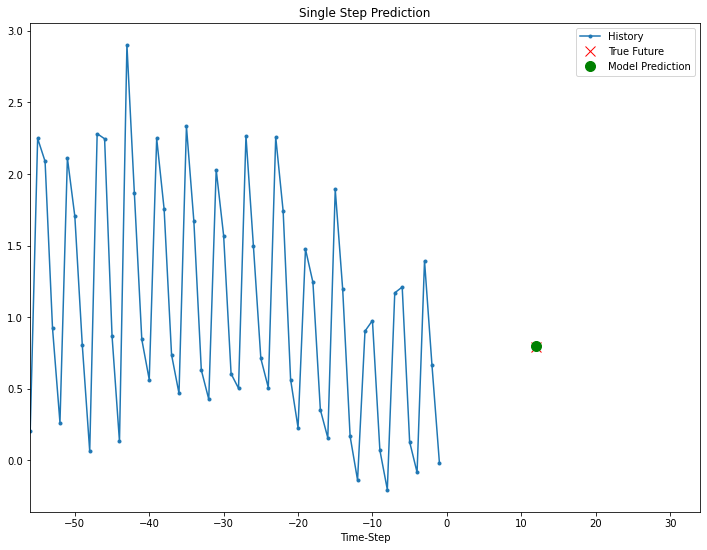

8/8 [==============================] - 0s 3ms/step


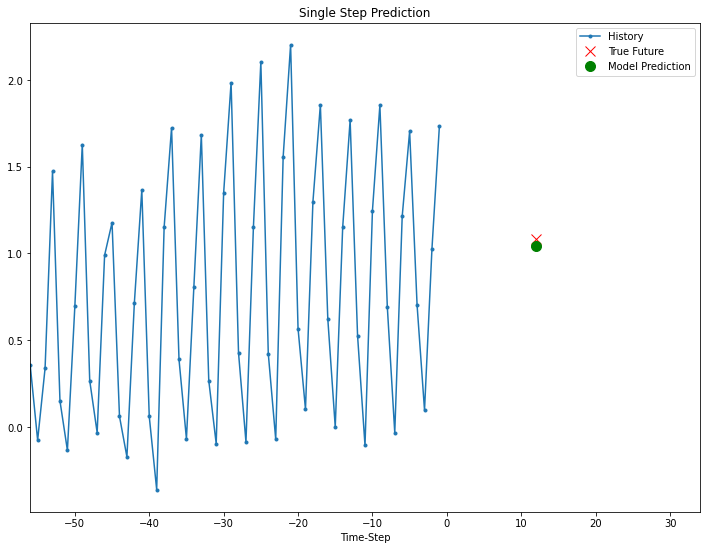

In [46]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()

### Multi-Step model
In a multi-step prediction model, given a past history, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predict a sequence of the future.

For the multi-step model, the training data again consists of recordings over the past five days sampled every hour. However, here, the model needs to learn to predict the temperature for the next 48 hours. Since an obversation is taken every 48 hours, the output is 48 predictions. For this task, the dataset needs to be prepared accordingly, thus the first step is just to create it again, but with a different target window.

In [76]:
future_target = 48
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

Let's check out a sample data-point.

In [48]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (56, 3)

 Target temperature to predict : (48,)


In [77]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

Plotting a sample data-point.

In [50]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(20, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

In this plot and subsequent similar plots, the history and the future data are sampled every hour.

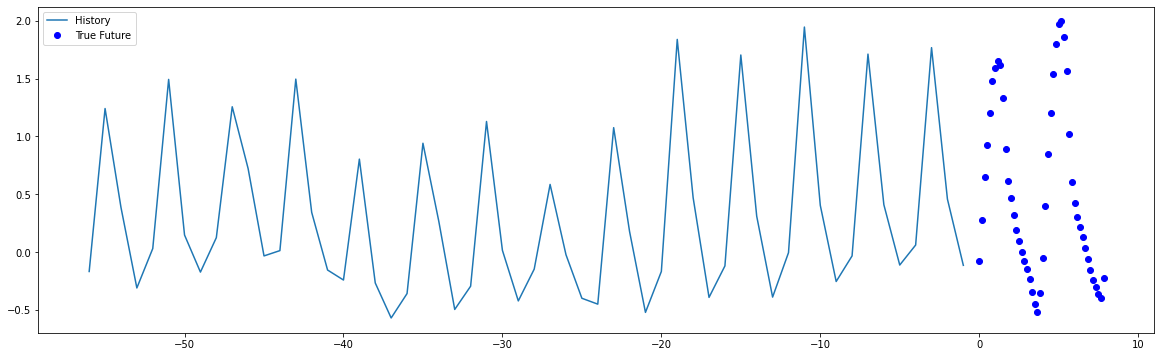

In [51]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

Since the task here is a bit more complicated than the previous task, the model now consists of two LSTM layers. Finally, since 48 predictions are made, the dense layer outputs 48 predictions.

In [52]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(48))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [53]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS_NEW,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/10
400/400 [==============================] - 43s 101ms/step - loss: 0.6056 - val_loss: 0.3075
Epoch 2/10
400/400 [==============================] - 41s 104ms/step - loss: 0.2843 - val_loss: 0.2389
Epoch 3/10
400/400 [==============================] - 42s 106ms/step - loss: 0.2373 - val_loss: 0.2011
Epoch 4/10
400/400 [==============================] - 41s 102ms/step - loss: 0.2086 - val_loss: 0.1895
Epoch 5/10
400/400 [==============================] - 40s 100ms/step - loss: 0.1992 - val_loss: 0.1919
Epoch 6/10
400/400 [==============================] - 41s 104ms/step - loss: 0.1969 - val_loss: 0.1847
Epoch 7/10
400/400 [==============================] - 41s 102ms/step - loss: 0.1928 - val_loss: 0.1821
Epoch 8/10
400/400 [==============================] - 42s 106ms/step - loss: 0.1919 - val_loss: 0.1793
Epoch 9/10
400/400 [==============================] - 41s 102ms/step - loss: 0.1884 - val_loss: 0.1729
Epoch 10/10
400/400 [==============================] - 40s 101ms/step - l

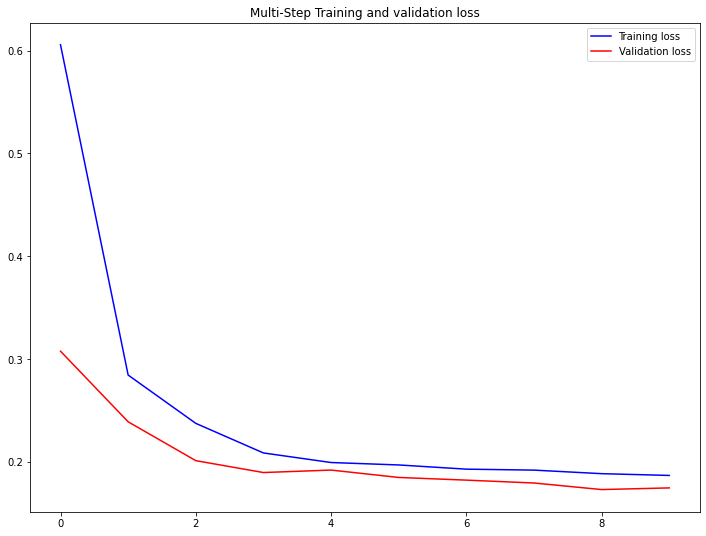

In [54]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

In [55]:
multi_step_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 56, 32)            4608      
                                                                 
 lstm_3 (LSTM)               (None, 16)                3136      
                                                                 
 dense_2 (Dense)             (None, 48)                816       
                                                                 
Total params: 8,560
Trainable params: 8,560
Non-trainable params: 0
_________________________________________________________________


In [78]:
for x, y in val_data_multi.take(5):
  diff = abs(denormalize(multi_step_model.predict(x)[0], data_mean[1], data_std[1]) - denormalize(np.array(y[0]), data_mean[1], data_std[1]))
  div = diff/denormalize(np.array(y[0]), uni_train_mean, uni_train_std)
  print("MAPE->", sum(div)/48)
  print("RMSE->", (sum(np.square(diff))/48)**0.5)
  print("-------------------------------------------------------")


8/8 [==============================] - 0s 9ms/step
MAPE-> 0.019090102991689267
RMSE-> 0.7734876016616054
-------------------------------------------------------
8/8 [==============================] - 0s 9ms/step
MAPE-> 0.020768396313582425
RMSE-> 0.7955802520703338
-------------------------------------------------------
8/8 [==============================] - 0s 9ms/step
MAPE-> 0.025997512171464957
RMSE-> 1.0387021048587863
-------------------------------------------------------
8/8 [==============================] - 0s 10ms/step
MAPE-> 0.03620595085169459
RMSE-> 1.357989184964896
-------------------------------------------------------
8/8 [==============================] - 0s 10ms/step
MAPE-> 0.015732162244642547
RMSE-> 0.5214031881361648
-------------------------------------------------------


#### Predict a multi-step future
Let's now have a look at how well your network has learnt to predict the future.

8/8 [==============================] - 0s 12ms/step


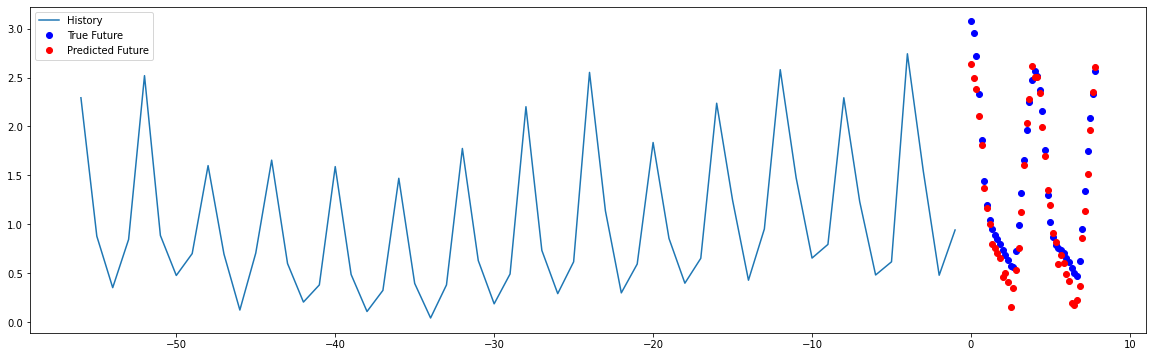

8/8 [==============================] - 0s 14ms/step


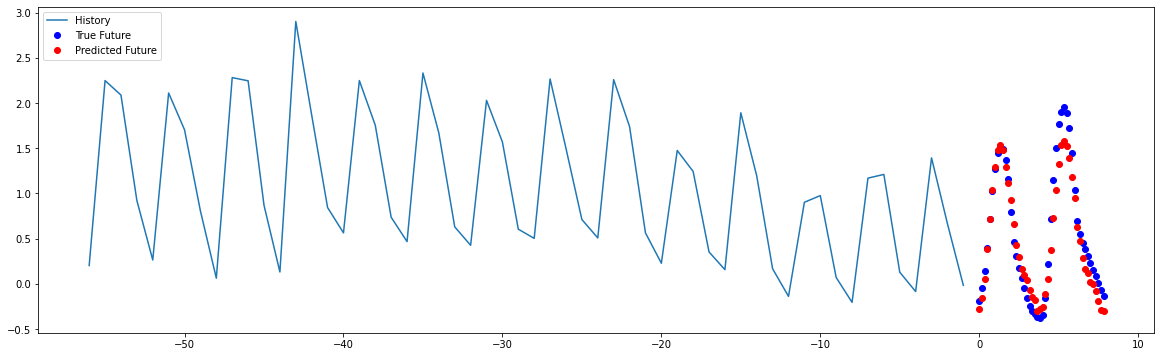

8/8 [==============================] - 0s 14ms/step


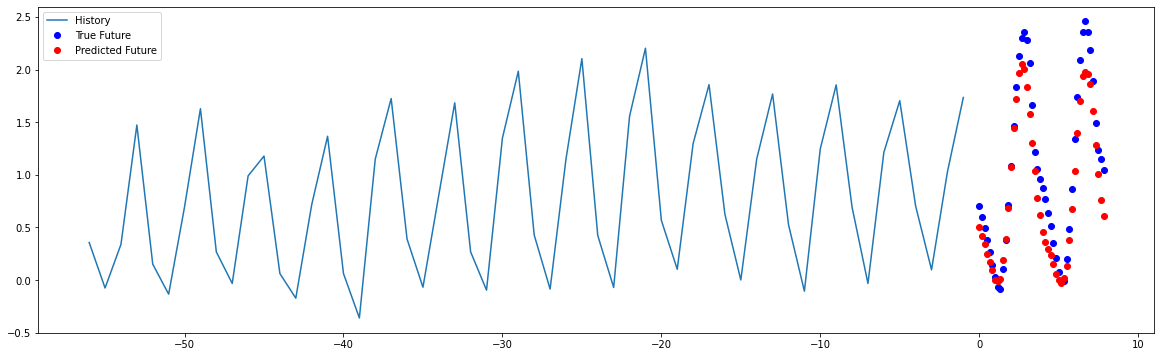

In [57]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

## We consider an additional feature i.e wind speed at 10M

In [58]:
features_considered_new = ['PS', 'T2M', 'QV2M', 'WS10M']

In [59]:
features = df[features_considered_new]
features.index = df['DATE_HOUR']
features.head()


,PS,T2M,QV2M,WS10M
DATE_HOUR,,,,
1-1-2012 Hr - 5,100.67,23.53,17.21,3.22
1-1-2012 Hr - 6,100.76,24.30,17.76,3.20
1-1-2012 Hr - 7,100.86,25.62,18.37,3.99
1-1-2012 Hr - 8,100.90,26.51,18.43,4.69
1-1-2012 Hr - 9,100.87,27.32,18.37,5.18


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7c9ff15bd0>,
      dtype=object)

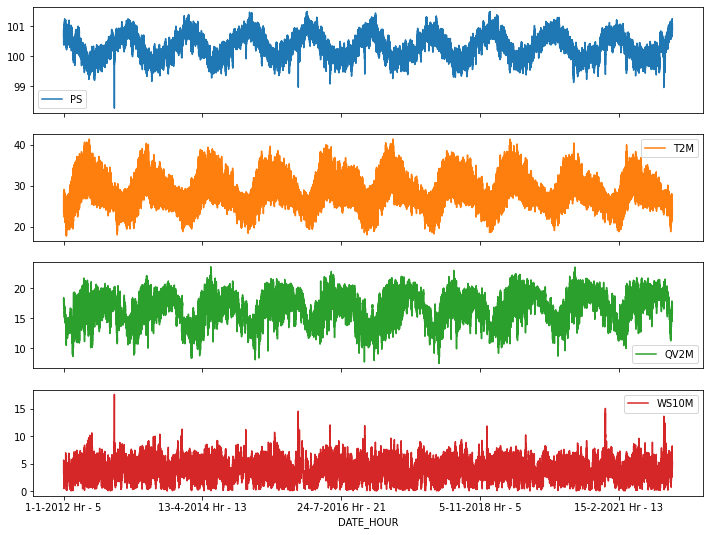

In [60]:
features.plot(subplots=True)

In [79]:
dataset_new = features.values
data_mean_new = dataset_new[:TRAIN_SPLIT].mean(axis=0)
data_std_new = dataset_new[:TRAIN_SPLIT].std(axis=0)

In [80]:
dataset_new = (dataset_new-data_mean_new)/data_std_new

In [81]:
future_target = 48
x_train_multi, y_train_multi = multivariate_data(dataset_new, dataset_new[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset_new, dataset_new[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [82]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [67]:
multi_step_model_new = tf.keras.models.Sequential()
multi_step_model_new.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model_new.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model_new.add(tf.keras.layers.Dense(48))

multi_step_model_new.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [68]:
multi_step_history = multi_step_model_new.fit(train_data_multi, epochs=EPOCHS_NEW,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/10
400/400 [==============================] - 46s 107ms/step - loss: 0.5394 - val_loss: 0.2705
Epoch 2/10
400/400 [==============================] - 42s 104ms/step - loss: 0.2733 - val_loss: 0.2243
Epoch 3/10
400/400 [==============================] - 40s 100ms/step - loss: 0.2329 - val_loss: 0.2062
Epoch 4/10
400/400 [==============================] - 40s 100ms/step - loss: 0.2075 - val_loss: 0.1952
Epoch 5/10
400/400 [==============================] - 41s 103ms/step - loss: 0.1974 - val_loss: 0.1891
Epoch 6/10
400/400 [==============================] - 41s 102ms/step - loss: 0.1941 - val_loss: 0.1834
Epoch 7/10
400/400 [==============================] - 42s 104ms/step - loss: 0.1895 - val_loss: 0.1789
Epoch 8/10
400/400 [==============================] - 40s 100ms/step - loss: 0.1881 - val_loss: 0.1813
Epoch 9/10
400/400 [==============================] - 40s 101ms/step - loss: 0.1845 - val_loss: 0.1723
Epoch 10/10
400/400 [==============================] - 41s 103ms/step - l

In [83]:
for x, y in val_data_multi.take(5):
  diff = abs(denormalize(multi_step_model_new.predict(x)[0], data_mean_new[1], data_std_new[1]) - denormalize(np.array(y[0]), data_mean_new[1], data_std_new[1]))
  div = diff/denormalize(np.array(y[0]), data_mean_new[1], data_std_new[1])
  # print("Predicted->", denormalize(multi_step_model_new.predict(x)[0], data_mean[1], data_std[1]))
  # print("Actual->", denormalize(np.array(y[0]), data_mean[1], data_std[1]))

  print("MAPE->", sum(div)*100/48)
  print("RMSE->", (sum(np.square(diff))/48)**0.5)
  print("-------------------------------------------")

8/8 [==============================] - 0s 9ms/step
MAPE-> 2.1734325482597585
RMSE-> 0.8594216942111721
-------------------------------------------
8/8 [==============================] - 0s 15ms/step
MAPE-> 2.0414641778186575
RMSE-> 0.7756823874399255
-------------------------------------------
8/8 [==============================] - 0s 19ms/step
MAPE-> 2.505555383450494
RMSE-> 1.0516046965532666
-------------------------------------------
8/8 [==============================] - 0s 18ms/step
MAPE-> 3.6442763239077287
RMSE-> 1.2561352290188474
-------------------------------------------
8/8 [==============================] - 0s 17ms/step
MAPE-> 1.5136192535078459
RMSE-> 0.5774985008160712
-------------------------------------------


8/8 [==============================] - 0s 10ms/step


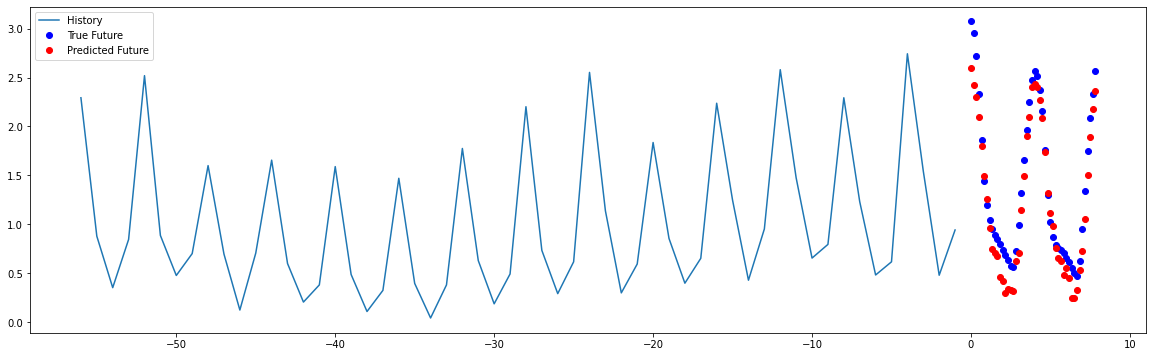

8/8 [==============================] - 0s 9ms/step


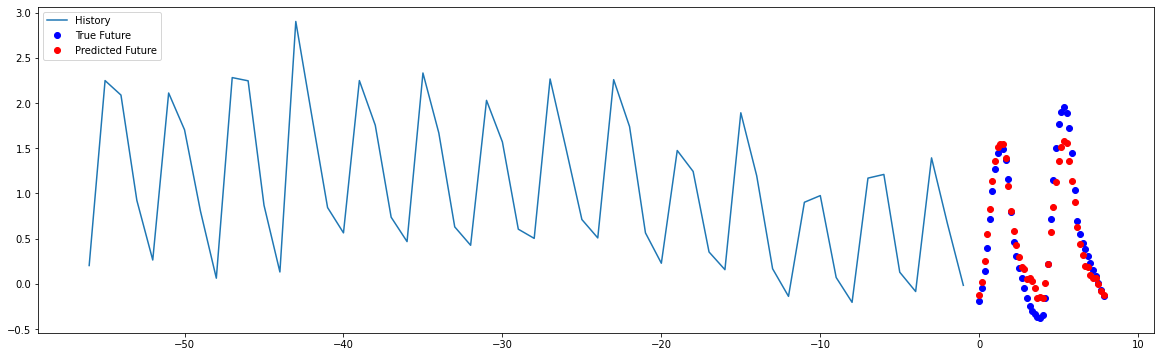

8/8 [==============================] - 0s 11ms/step


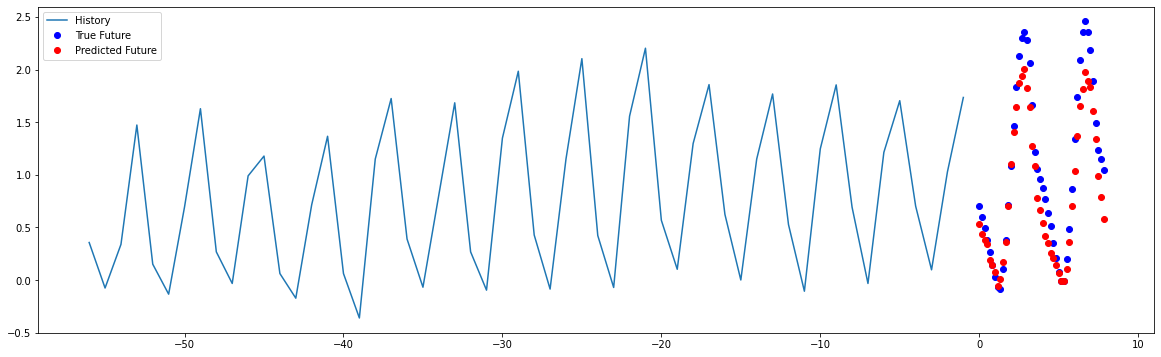

In [84]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model_new.predict(x)[0])